<a href="https://colab.research.google.com/github/INIT-FIU-Hardware-Build-Spring2024/ASL-Glove/blob/main/HandGestureStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

Converting non-numeric data in column Orientation-Z-Right-Frame-20 to numeric
Removing 1 rows with NaN in SIGN column
Classes: ['PROUD' 'STUDENT' 'THANK YOU' 'THIS' 'WE' 'WORK']
Number of classes: 6

Performing 5-fold cross-validation:

Random Forest Cross-Validation Results:
Individual fold accuracies: [1.         0.99563319 1.         0.99781659 1.        ]
Mean accuracy: 0.9987
Standard deviation: 0.0017

Top 20 most important features:
                         Feature  Importance
271        Flex-Right-3-Frame-12    0.021900
194  Orientation-Y-Left-Frame-12    0.019913
209  Orientation-Y-Left-Frame-17    0.019246
206  Orientation-Y-Left-Frame-16    0.017997
215  Orientation-Y-Left-Frame-19    0.016544
297        Flex-Right-4-Frame-18    0.016402
293        Flex-Right-4-Frame-14    0.015390
234        Flex-Right-1-Frame-15    0.014432
270        Flex-Right-3-Frame-11    0.014350
195  Orientation-Z-Left-Frame-12    0.014335
275        Flex-Right-3-Frame-16    0.014273
233        Flex-

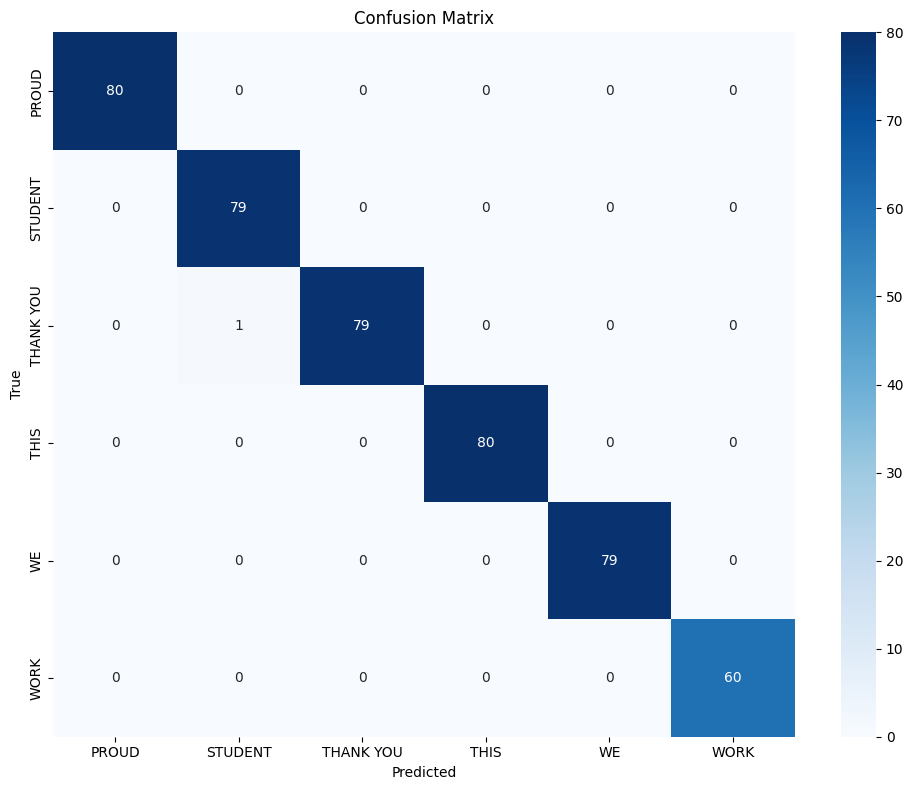

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Reading Data Into DataFrame
all_data = []
csv1 = "sensors_data_1.csv"
csv2 = "sensors_data_2.csv"
csv3 = "sensors_data_3.csv"
csv4 = "sensor_data_4.csv"

# test
#testcsv = "combined.csv"

df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)
df3 = pd.read_csv(csv3)
df4 = pd.read_csv(csv4)

# test
#testdf = pd.read_csv(testcsv)

all_data.append(df1)
all_data.append(df2)
all_data.append(df3)
all_data.append(df4)

# test
#all_data = [testdf]

# ADDED: Check and convert non-numeric values in feature columns before concatenation
for i, df in enumerate(all_data):
    for col in df.columns:
        if col != "SIGN":  # Skip the SIGN column
        #if col != "Gesture":
            # Check if column has non-numeric data
            if df[col].dtype == 'object':
                print(f"Converting non-numeric data in column {col} to numeric")
                # Convert to numeric, forcing non-convertible values to NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')

            # Fill any NaN values with column median
            if df[col].isna().any():
                df[col] = df[col].fillna(df[col].median())

    # Update the dataframe in the list
    all_data[i] = df

df = pd.concat(all_data, ignore_index=True)

# ADDED: Final check for any remaining non-numeric values
for col in df.columns:
    if col != "SIGN" and not pd.api.types.is_numeric_dtype(df[col]):
    #if col != "Gesture" and not pd.api.types.is_numeric_dtype(df[col]):
        print(f"Warning: Column {col} is still non-numeric after cleaning")
        # Force convert again if needed
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

#---------------------------------------------------------------------
# 1. Identify which column in your DataFrame is the 'output' or label
#---------------------------------------------------------------------
label_col = "SIGN"  # Replace if needed
#label_col = "Gesture"

# ADDED: Clean NaN values in the SIGN column
if df[label_col].isna().any():
    print(f"Removing {df[label_col].isna().sum()} rows with NaN in SIGN column")
    df = df.dropna(subset=[label_col])

#---------------------------------------------------------------------
# 2. Separate features (X) and target/label (y) BEFORE scaling
#---------------------------------------------------------------------
X = df.drop(label_col, axis=1)
y = df[label_col]

#---------------------------------------------------------------------
# 3. Encode the output variable (string labels → integers)
#---------------------------------------------------------------------
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(f"Classes: {encoder.classes_}")
print(f"Number of classes: {len(encoder.classes_)}")

#---------------------------------------------------------------------
# 4. Scale the features AFTER separating from labels
#    This prevents data leakage
#---------------------------------------------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#---------------------------------------------------------------------
# 5. Implement Cross-Validation
#---------------------------------------------------------------------
# First, let's implement models with more careful parameter settings
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,  # Increased from 10 to 100
        max_depth=None,
        random_state=42
    ),
    "SVM": SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )
}

# Set up cross-validation with k=5 folds
n_folds = 5
print(f"\nPerforming {n_folds}-fold cross-validation:")

# Use StratifiedKFold to maintain class distribution
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for name, model in models.items():
    # Get cross-validation scores
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=skf, scoring='accuracy')

    # Print results
    print(f"\n{name} Cross-Validation Results:")
    print(f"Individual fold accuracies: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation: {cv_scores.std():.4f}")

    # Train on full data and report feature importance if it's Random Forest
    model.fit(X_scaled, y_encoded)

    if name == "Random Forest":
        # Get feature importance
        feature_importance = model.feature_importances_

        # Create DataFrame of feature importance
        feat_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)

        # Show top 20 most important features
        print("\nTop 20 most important features:")
        print(feat_importance_df.head(20))

#---------------------------------------------------------------------
# 6. Additional Analysis - Train/Test Evaluation for Detailed Metrics
#---------------------------------------------------------------------
from sklearn.model_selection import train_test_split

# Create a single train/test split for additional analysis
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # Ensure class distribution is maintained
)

# Evaluate the best model (based on cross-validation)
best_model = models["SVM"]  # Change this if RF performs better
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Print comprehensive evaluation metrics
print("\nDetailed Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix (comment out if not needed)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib or Seaborn not available for confusion matrix visualization")

In [ ]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Reading Data Into DataFrame
csv = "/content/handdata.csv"
df = pd.read_csv(csv)

#---------------------------------------------------------------------
# 1. Identify which column in your DataFrame is the 'output' or label.
#    Let's assume it is named "Gesture" in your CSV (adjust as needed).
#---------------------------------------------------------------------
label_col = "SIGN"  # <-- Replace with the actual name of your label column.

#---------------------------------------------------------------------
# 2. Scale (normalize) only the feature columns, NOT the label column.
#---------------------------------------------------------------------
scaler = MinMaxScaler()
cols_to_scale = df.columns.drop(label_col)  # everything except the label
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

#---------------------------------------------------------------------
# 3. Separate features (X) and target/label (y)
#---------------------------------------------------------------------
X = df.drop(label_col, axis=1)
y = df[label_col]

#---------------------------------------------------------------------
# 4. Encode the output variable (string labels → integers).
#    If your CSV already has string labels like "THANK YOU", "WE", etc.,
#    you only need to fit the encoder to that column (y).
#---------------------------------------------------------------------
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

#---------------------------------------------------------------------
# 5. Split into train/test sets
#---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 3. Initialize Random Forest
#    - n_estimators: number of trees in the forest
#    - max_depth: maximum depth of each tree (None -> grow until leaves are pure)
#    - random_state: for reproducibility
rf_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=None,
    random_state=42
)

# 4. Train (fit) the model
rf_model.fit(X_train, y_train)

# 5. Make predictions on test data
y_pred = rf_model.predict(X_test)

# 6. Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
model.fit(X_train, y_train)

# 5. Make predictions and evaluate
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        26

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119

Confusion Matrix:
[[17  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 23  0  0  0]
 [ 0  0  0 18  0  0]
 [ 0  0  0  0 23  0]
 [ 0  0  0  0  0 26]]
